In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import random
from torch.utils.data.dataset import TensorDataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from torch.optim import Adam
from pytorch_lightning import Trainer
import os
import numpy as np
import pandas as pd
from os.path import join
from typing import Optional
from config import processed_data_path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
# TODO: Add denoising criterion; Representation spartsity

In [2]:
# Defining the dataset
class _dataset(Dataset): #
    def __init__(self, variant, category, random_seed=42, tensor=True):
        """ 
        variant -> 'VLQ_HG', 'VLQ_SEM_HG', 'bkg', 'FCNC'
        category -> 'train, validation', 'test', 'all'
        tensor -> if true will return the data as a tensor, if False will return as a DataFrame
        """
        # TODO: Improve efficiency/handle names
        
        # Sanity checks
        assert variant in {'VLQ_HG', 'VLQ_SEM_HG', 'bkg', 'FCNC'}, "Invalid variant!"
        assert category in {'train', 'validation', 'test', 'all'}, "Invalid category!"

        # With specified variant, get data
        file = join(processed_data_path, variant + ".csv")
        data = pd.read_csv(file, index_col=0)

        # Shuffle the dataframe
        data = data.sample(frac=1, random_state=random_seed).reset_index(drop=True)

        # This will equally devide the dataset into 
        # train, validation and test
        train, validation, test = np.split(data.sample(frac=1), [int(len(data)*(1/3)), int(len(data)*(2/3))])
        
        if category == "train":
            data = train
        elif category == "validation":
            data = validation
        elif category == "test":
            data = test
        elif category == "all":
            del train, validation, test
            self.data = data
        
        # This data we want on a seperate variable
        if category != "all":
            # Weights
            if tensor:
                self.weights = torch.from_numpy(data["weights"].to_numpy(dtype=np.float32))
            else:
                self.weights = data["weights"]
            # Name
            self.name = data["name"]

            data.drop(["name", "weights"], axis=1, inplace=True)
            # Data
            if tensor:
                self.data = torch.from_numpy(data.to_numpy(dtype=np.float32))
            else:
                self.data = data
            self.n_samples = data.shape[0]


    def __getitem__(self, index):
        return self.data[index], self.weights[index]

    def __len__(self):
        return self.n_samples

    def all_data(self):
        return self.data

In [3]:
class VAE(pl.LightningModule):
    def __init__(self, dataset, batch_size, hidden_size, alpha, lr):
        """
        Args:
        - > variant e {'VLQ_HG', 'VLQ_SEM_HG', 'bkg', 'FCNC'}; it's the type of data
        - > hidden_size : Latent Hidden Size
        - > alpha : Hyperparameter to control the importance of
        reconstruction loss vs KL-Divergence Loss
        - > lr : Learning Rate, will not be used if auto_lr_find is used.
        - > dataset : Dataset to used
        """
        super().__init__()
        self.dataset = dataset
        self.batch_size = batch_size
        self.hparams.batch_size = batch_size
        self.hidden_size = hidden_size
        self.lr = lr
        self.alpha = alpha

        # Architecture
        self.encoder = nn.Sequential(
            nn.Linear(69, 128), 
            nn.LeakyReLU(), 
            nn.Linear(128, 128),
            nn.LeakyReLU(), 
            nn.Linear(128, hidden_size),
            nn.LeakyReLU()
        )

        self.hidden2mu = nn.Linear(hidden_size, hidden_size)
        self.hidden2log_var = nn.Linear(hidden_size, hidden_size)
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, 128), 
            nn.LeakyReLU(), 
            nn.Linear(128, 128),
            nn.LeakyReLU(), 
            nn.Linear(128, 69), 
            nn.LeakyReLU(),
        )

    def encode(self, x):
        # Pass through encoder
        out = self.encoder(x)
        mu = self.hidden2mu(out)
        log_var = self.hidden2log_var(out)
        return mu, log_var

    def decode(self, x):
        # Pass through encoder
        return self.decoder(x)

    def reparametrize(self, mu, log_var):
        # Reparametrization Trick
        # It outputs a sample of the dist.
        # mu -> average | log_var -> std
        
        log_var = torch.exp(0.5*log_var)
        z = torch.randn(size=(mu.size(0), mu.size(1))) # log_var, normal distribution
        z = z.type_as(mu)
        return mu + log_var*z

    def forward(self, x):
        # Pass through encoder
        mu, log_var = self.encode(x)
        # Reparametrization Trick
        hidden = self.reparametrize(mu, log_var)
        # Pass through decoder
        output = self.decoder(hidden)

        return mu, log_var, output, hidden

    def training_step(self, batch, batch_idx):
        x, weights = batch
        # Pass
        mu, log_var, x_out, _ = self.forward(x)

        # Losses
        kl_loss = (-0.5*(1+log_var - mu**2 -
                         torch.exp(log_var)).sum(dim=1)).mean(dim=0)

        recon_loss_criterion = nn.MSELoss()
        recon_loss = recon_loss_criterion(x, x_out)

        loss = recon_loss*self.alpha + kl_loss

        # Weights on final loss
        loss = (weights * loss) / weights.sum()
        loss = torch.mean(loss, dtype=torch.float32)

        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, weights = batch

        mu, log_var, x_out, _ = self.forward(x)

        # K-L Loss
        #kl_loss = (-0.5*(1+torch.log(log_var**2)-log_var**2 - mu**2).sum(dim=1)).mean(dim=0) 
        kl_loss = (-0.5*(1+log_var - mu**2 -
                         torch.exp(log_var)).sum(dim=1)).mean(dim=0)
        # Weights on KL Loss
        kl_loss = (weights * kl_loss) / weights.sum()
        kl_loss = torch.mean(kl_loss, dtype=torch.float32)

        # Reconstruction loss
        recon_loss_criterion = nn.MSELoss()
        recon_loss = recon_loss_criterion(x, x_out)
        # Weights on recon loss
        recon_loss = (weights * recon_loss) / weights.sum()
        recon_loss = torch.mean(recon_loss, dtype=torch.float32)


        loss = recon_loss*self.alpha + kl_loss

        self.log('val_kl_loss', kl_loss, on_step=False, on_epoch=True)
        self.log('val_recon_loss', recon_loss, on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)

        return x_out, loss

    def test_step(self, batch):
        ### WIP
        x = batch
        mu, log_var, x_out, hidden = self.forward(x)

        # Loss
        kl_loss = (-0.5*(1+log_var - mu**2 -
                         torch.exp(log_var)).sum(dim=1)).mean(dim=0)
        recon_loss_criterion = nn.MSELoss()
        recon_loss = recon_loss_criterion(x, x_out)
        loss = recon_loss*self.alpha + kl_loss

        return  mu, log_var, x_out, hidden

    def validation_epoch_end(self, outputs):
        pass

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr)

    # Functions for dataloading
    def train_dataloader(self):
        train_set = _dataset(self.dataset, category="train")
        return DataLoader(train_set, batch_size=self.batch_size, num_workers=12)

    def val_dataloader(self):
        val_set = _dataset(self.dataset, category="validation")
        return DataLoader(val_set, batch_size=self.batch_size, num_workers=12)

    def test_dataloader(self):
        val_set = _dataset(self.dataset, category="test")
        return DataLoader(val_set, batch_size=self.batch_size, num_workers=12)


### Training

In [ ]:

from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

if __name__ == "__main__":
    logger = TensorBoardLogger("lightning_logs")
    trainer = Trainer(
        # fast_dev_run = True,
        gpus=1,
        #auto_lr_find=True,
        max_epochs=500,
        #max_time=
        callbacks=[EarlyStopping(monitor="val_loss", patience=100), ModelCheckpoint(dirpath="models", monitor="val_loss", mode="min")],
        logger=logger,
        precision=16
        )
    model = VAE(
    dataset = "bkg",
    hidden_size=2,
    batch_size = 2048,
    alpha = 10, 
    lr = 0.0001,
    )
    #trainer.tune(model) 
    trainer.fit(model)


# Anomaly Detection

### Load Model

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

In [5]:
model = VAE.load_from_checkpoint(
    "./models/epoch=455-step=82535.ckpt", 
    dataset = "bkg",
    hidden_size=2,
    batch_size = 2048,
    alpha = 10, 
    lr = 0.0001)
    
model.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=69, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=2, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (hidden2mu): Linear(in_features=2, out_features=2, bias=True)
  (hidden2log_var): Linear(in_features=2, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=69, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
)

### Load data

In [6]:
# Sinal
data = pd.concat([
     _dataset(category='all',variant='VLQ_HG').all_data()
    ,_dataset(category='all',variant='VLQ_SEM_HG').all_data()
    ,_dataset(category='all',variant='FCNC').all_data()
    ])

# Bkg
bkg = _dataset(category='test',variant='bkg', tensor=False).all_data()
bkg['name'] = 'background.csv'
data = pd.concat([data, bkg])

data.drop(columns=['weights'], inplace=True)
data.describe()


/home/acujl/.local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


FatJet_Multi     FatJet1_PT     FatJet2_PT     FatJet3_PT  \
count  527817.000000  527817.000000  527817.000000  527817.000000   
mean        0.000048       0.000124      -0.000462       0.000280   
std         1.000030       1.000513       1.000803       0.999272   
min        -5.319242      -4.101005      -2.998802      -1.426919   
25%        -0.506770      -0.581481      -0.856784      -0.459476   
50%        -0.114884      -0.042394      -0.132059      -0.220869   
75%         0.791427       0.538006       0.705342      -0.171740   
max         8.250492      15.280784      12.069780      18.494353   

          FatJet4_PT     FatJet5_PT   FatJet1_Mass   FatJet2_Mass  \
count  527817.000000  527817.000000  527817.000000  527817.000000   
mean       -0.001380       0.000669       0.000185      -0.000410   
std         0.982165       1.023615       0.999689       1.001101   
min        -0.605231      -0.189027      -3.535721      -2.437524   
25%        -0.129339      -0.031524      -0.785255      -0.742107   
50%        -0.096728      -0.024664      -0.068710      -0.331509   
75%        -0.047287      -0.010815       0.635114       0.578409   
max        39.224680     215.089917      19.916800      11.840978   

        FatJet3_Mass   FatJet4_Mass  ...  Electron_Multi   Electron1_PT  \
count  527817.000000  527817.000000  ...   527817.000000  527817.000000   
mean        0.000438      -0.001831  ...        0.001300       0.001837   
std         1.002033       0.963487  ...        1.000032       1.001918   
min        -1.199560      -0.539097  ...       -1.336158      -1.218623   
25%        -0.388786      -0.113399  ...       -0.810386      -0.710694   
50%        -0.193727      -0.086368  ...       -0.781252      -0.572371   
75%        -0.151859      -0.041419  ...        1.198572       0.538037   
max        24.233887      52.642710  ...        4.526157      11.705100   

        Electron2_PT  Electron1_Eta  Electron2_Eta  Electron1_Phi  \
count  527817.000000  527817.000000  527817.000000  527817.000000   
mean        0.001449       0.001317       0.000875       0.000676   
std         1.002140       1.000414       1.000047       1.000130   
min        -0.673532      -4.252402      -5.476268      -2.823079   
25%        -0.534342      -0.005541      -0.004436      -0.004365   
50%        -0.486734       0.000813      -0.000362      -0.000101   
75%         0.184135       0.007525       0.001253       0.008770   
max        14.925601       4.244300       5.479251       2.827633   

       Electron2_Phi  MissingET_MET  MissingET_Phi    ScalarHT_HT  
count  527817.000000  527817.000000  527817.000000  527817.000000  
mean       -0.000174       0.000165      -0.000951       0.000294  
std         1.001014       0.999854       1.000490       1.000803  
min        -4.061617      -1.529808      -1.755112      -2.533251  
25%        -0.000624      -0.663430      -0.867306      -0.705418  
50%         0.001715      -0.273493      -0.002278      -0.241849  
75%         0.005244       0.370709       0.866797       0.449338  
max         4.044430      18.965416       1.774142      14.105228  

[8 rows x 69 columns]

## Check if z ~ N(0,1)

In [8]:
mu, log_var, x_out, hidden = model.test_step(torch.from_numpy(data.drop(columns=['name']).to_numpy(dtype=np.float32)))
hidden = hidden.detach().numpy()
hidden.shape

(527817, 2)

In [9]:
z0 = hidden[:, 0]
z1 = hidden[:, 1]
z0.shape, z1.shape

((527817,), (527817,))

Mean: -0.00037095774 Std: 1.0003985


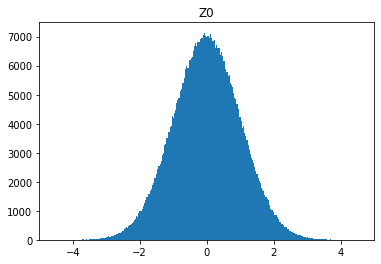

In [11]:
_ = plt.hist(z0, bins='auto')
plt.xlim(-5, 5)
plt.title("Z0")
print("Mean:", z0.mean(), "Std:", z0.std())


Mean: 0.014779965 Std: 1.0995604


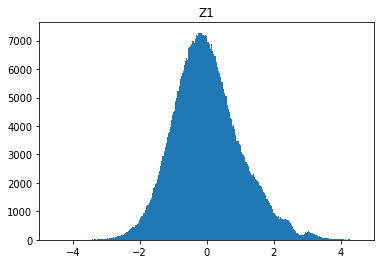

In [12]:
_ = plt.hist(z1, bins='auto')
plt.xlim(-5, 5)
plt.title("Z1")
print("Mean:", z1.mean(), "Std:", z1.std())


## Random sampling and comparing distributions with bkg data

In [145]:
bkg.drop(columns=['name'], inplace=True)

In [146]:
# Sampling from validation
#_ , _, sample, _ = model.test_step(_dataset(category='validation',variant='bkg').all_data())

# Random sample from N(0,1)
sample = np.vstack([model.decode(torch.rand(2)).detach().numpy() for x in range(bkg.shape[0])])

# Make it a dataframe
sample = pd.DataFrame(sample.detach().numpy(), columns=bkg.columns)


AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [131]:
sample.describe()


FatJet_Multi     FatJet1_PT     FatJet2_PT     FatJet3_PT  \
count  370197.000000  370197.000000  370197.000000  370197.000000   
mean       -0.003613      -0.003817      -0.005241       0.013560   
std         0.535267       0.448584       0.388494       0.705365   
min       -17.399160     -17.540735     -15.183303      -0.232474   
25%        -0.253061      -0.260407      -0.225739      -0.212949   
50%        -0.013283      -0.017127      -0.015990      -0.160514   
75%         0.144036       0.200747       0.174506      -0.010342   
max         6.085466       3.310103       3.238369      22.191618   

          FatJet4_PT     FatJet5_PT   FatJet1_Mass   FatJet2_Mass  \
count  370197.000000  370197.000000  370197.000000  370197.000000   
mean       -0.003492      -0.000171      -0.000966      -0.007346   
std         0.895992       0.886633       0.441239       0.317699   
min        -0.784030      -0.084052     -14.097918     -11.460405   
25%        -0.083361      -0.018840      -0.267655      -0.190760   
50%        -0.082090      -0.017452      -0.054708      -0.026239   
75%        -0.080320      -0.016080       0.220782       0.159362   
max        23.436668     161.620483       1.323768       2.612387   

        FatJet3_Mass   FatJet4_Mass  ...  Electron_Multi   Electron1_PT  \
count  370197.000000  370197.000000  ...   370197.000000  370197.000000   
mean        0.013252      -0.001951  ...       -0.010432      -0.007639   
std         0.688456       0.849227  ...        0.007629       0.052232   
min        -0.208714      -0.691971  ...       -0.132901      -1.490804   
25%        -0.195967      -0.073853  ...       -0.016307      -0.021823   
50%        -0.150814      -0.071053  ...       -0.006558      -0.003819   
75%        -0.011488      -0.067611  ...       -0.004263      -0.002295   
max        61.086506      24.633116  ...       -0.000817       1.608860   

        Electron2_PT  Electron1_Eta  Electron2_Eta  Electron1_Phi  \
count  370197.000000  370197.000000  370197.000000  370197.000000   
mean       -0.009652      -0.002293      -0.002281      -0.003638   
std         0.044041       0.000998       0.001054       0.004609   
min        -1.650855      -0.169630      -0.169209      -0.229588   
25%        -0.023990      -0.002719      -0.002513      -0.004078   
50%        -0.002223      -0.002280      -0.002099      -0.003260   
75%        -0.001126      -0.001664      -0.001795      -0.003018   
max         0.769338      -0.001077      -0.001457       2.627181   

       Electron2_Phi  MissingET_MET  MissingET_Phi    ScalarHT_HT  
count  370197.000000  370197.000000  370197.000000  370197.000000  
mean       -0.001052       0.001762      -0.003497      -0.006925  
std         0.000598       0.108017       0.001131       0.604281  
min        -0.119229      -0.034267      -0.016890      -7.919651  
25%        -0.001263      -0.031975      -0.003649      -0.336874  
50%        -0.000908      -0.025289      -0.003203      -0.160968  
75%        -0.000774      -0.002384      -0.002999       0.097663  
max         0.030783      43.998783      -0.000899       7.964254  

[8 rows x 69 columns]

In [132]:
def plot_graphs2(background, signal, bins=50, num_cols=4):

    # Ignoring irrelevant features such as 'name' and 'weights' in
    # the plotting of the data
    features  = list(background.columns)
    for x in ['name', 'weights']: 
        try:
            features.remove(x)
        except:
            pass

    # Plot creation
    num_rows = int(np.ceil((len(list(signal.columns)) - 1) / num_cols)) +1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    for x in tqdm(features, total=len(features), desc="Processing..."):

        # Plot  
        row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        i += 1


        # Define histogram range
        hist_min = min(signal[x].min(), background[x].min())
        hist_max = max(signal[x].max(), background[x].max())
        hist_range = (hist_min, hist_max)


        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(background[x], bins=bins, alpha=0.5, label='Real', range=hist_range)
        ax[row, col].hist(signal[x], bins=bins, alpha=0.5, label='Sampled',  range=hist_range)
        
        ax[row, col].autoscale(enable=True) 
        ax[row, col].legend()
        

    fig.tight_layout()
    plt.savefig('1_explore_data.png', bbox_inches='tight', dpi=100)
    plt.show()
    

Processing...:   0%|          | 0/69 [00:00<?, ?it/s]

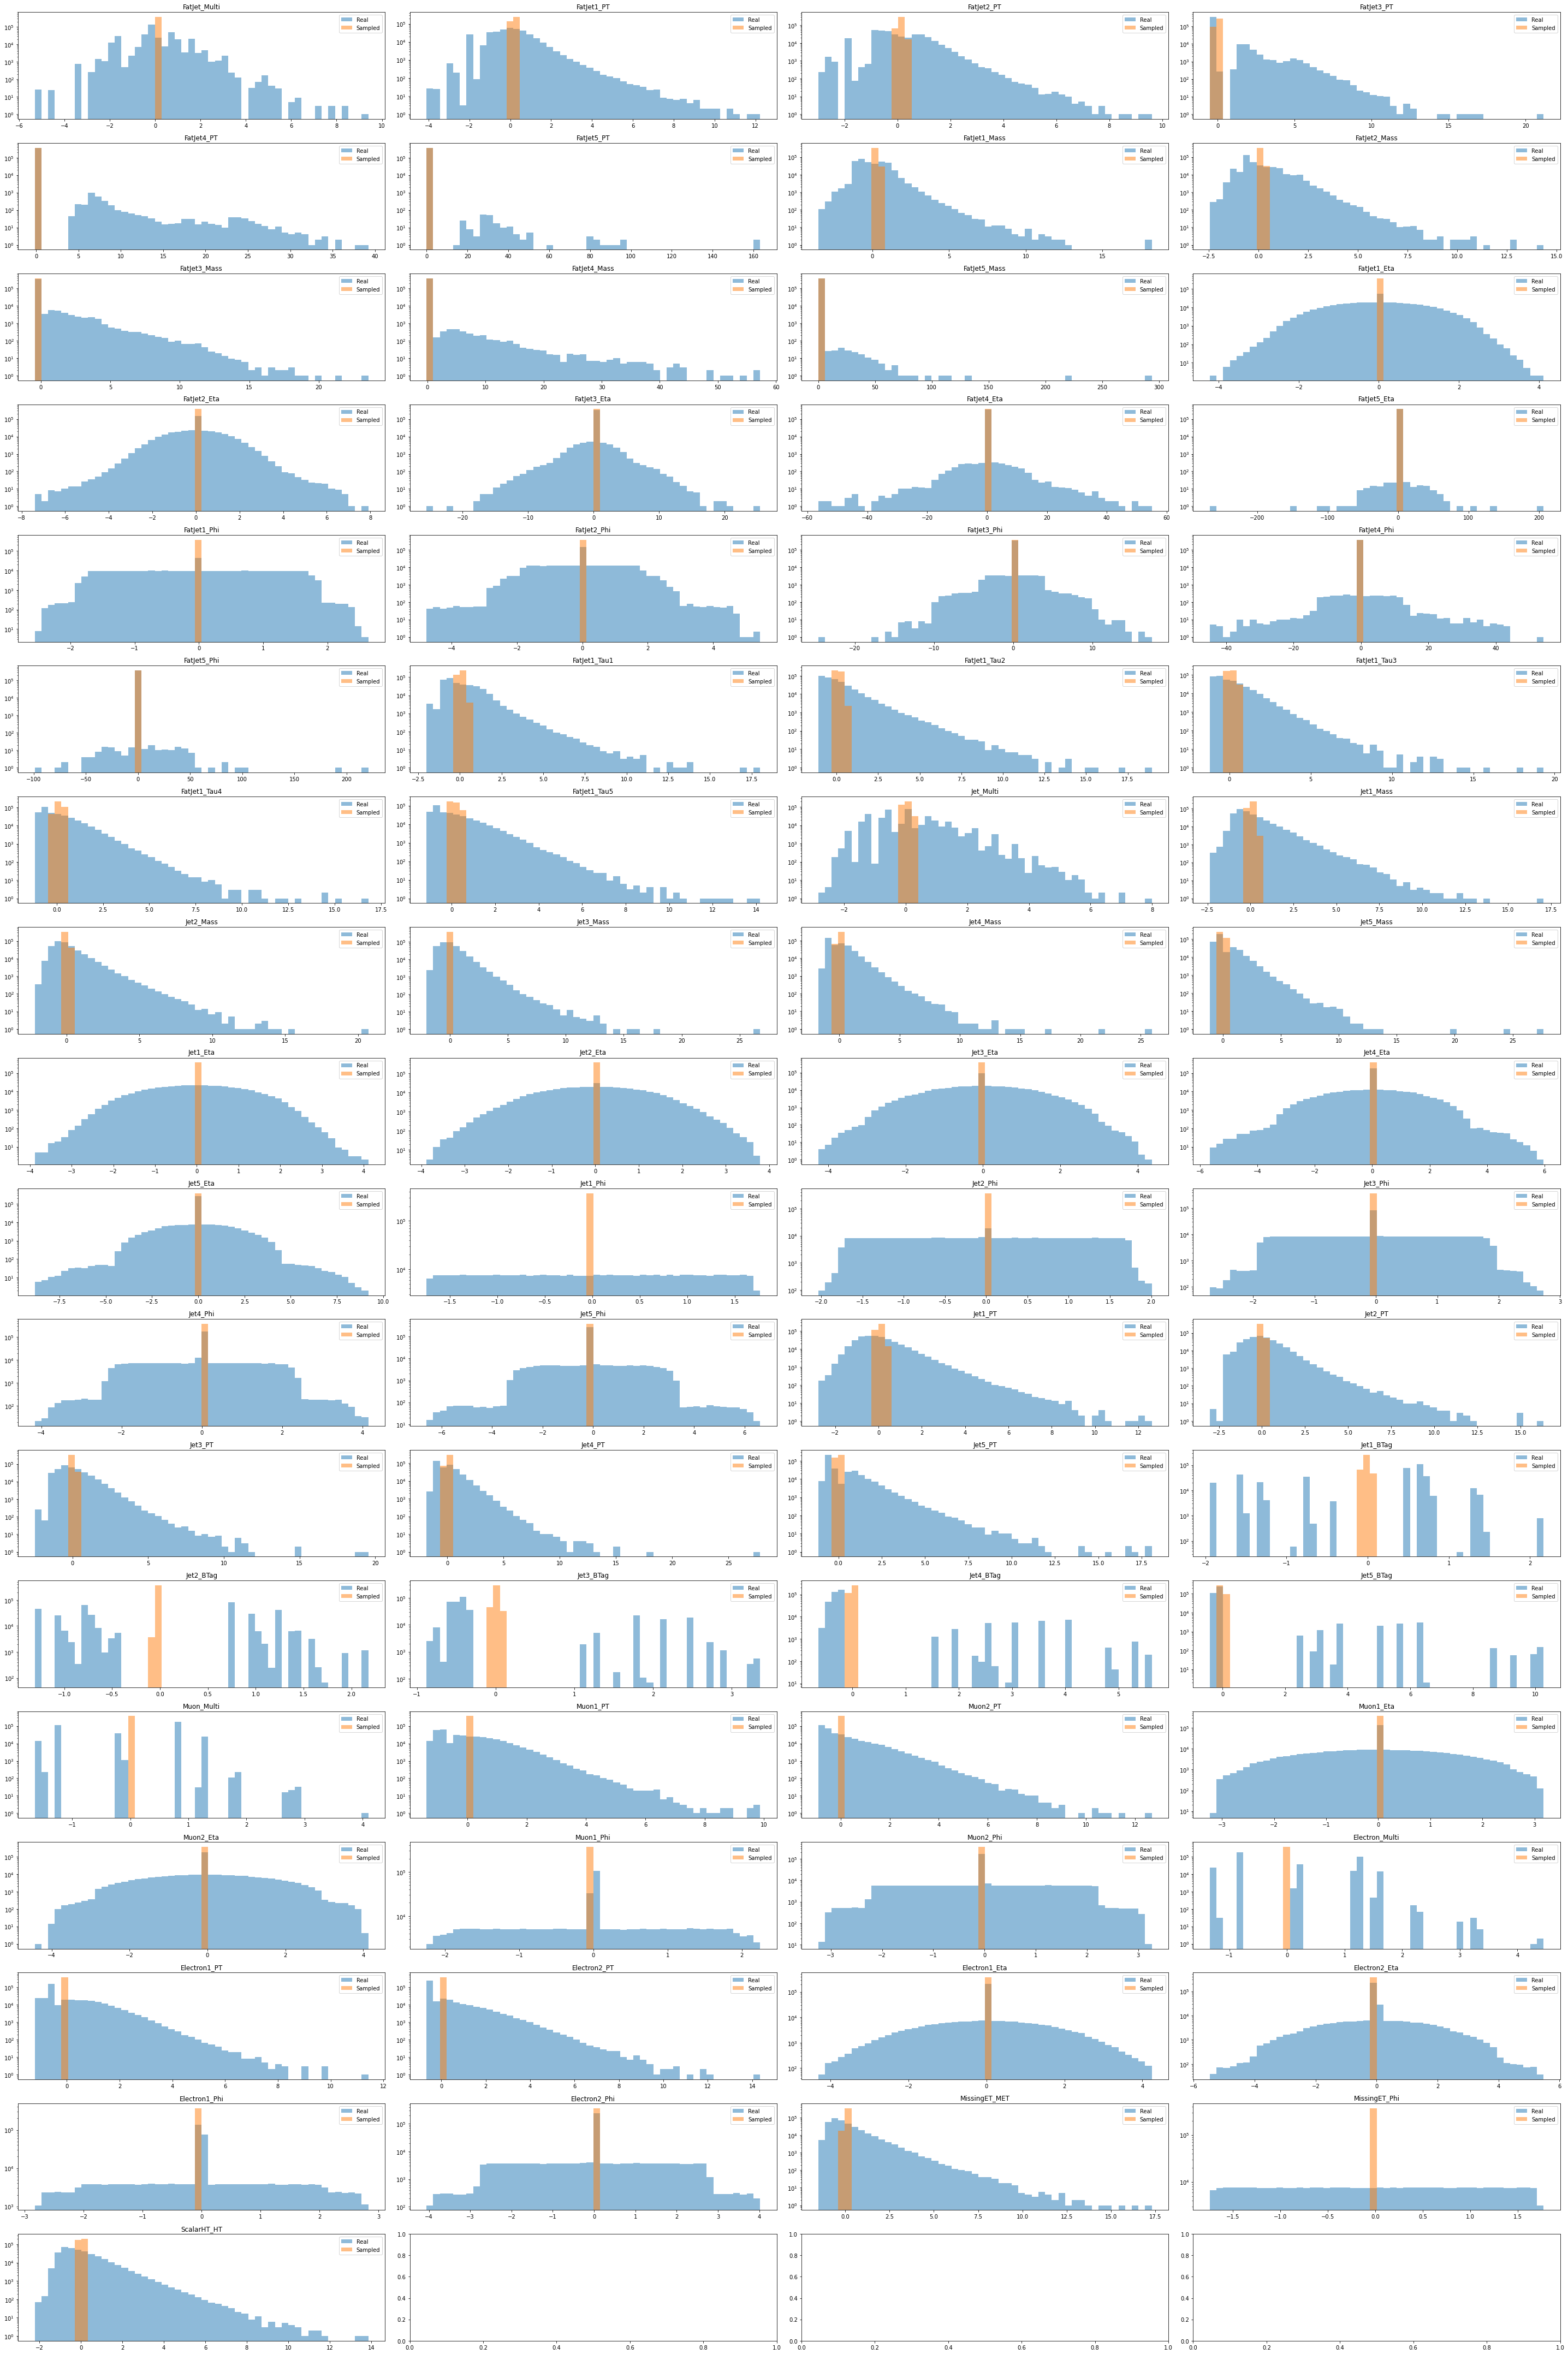

In [133]:
plot_graphs2(bkg, sample_df)

Plot

  0%|          | 0/6 [00:00<?, ?it/s]

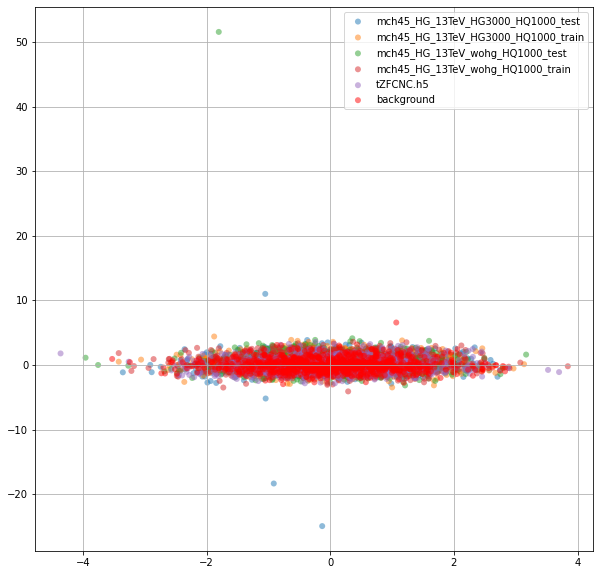

In [147]:
fig, ax = plt.subplots( figsize=(10,10))
for x in tqdm(data['name'].unique()):
    mu, log_var, x_out, hidden = model.test_step(torch.from_numpy(data.loc[data['name'] == x].drop(columns=['name']).to_numpy(dtype=np.float32)))
    hidden = hidden.detach().numpy()

    if x != 'background.csv':
        color = None
    else:
        color = 'r'

    ax.scatter(hidden[:1000, 0], hidden[:1000, 1], label=x.replace('.csv', ''), alpha=0.5, edgecolors='none', c = color)

ax.legend()
ax.grid(True)

plt.show()
